In [85]:
import os
import pandas as pd
pd.options.display.max_rows = 10
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import lightgbm as lightgbm
import xgboost as xgb

start = time.time()
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test_features = pd.read_csv('test_features.csv')
test_labels = pd.read_csv('test_labels.csv')

#pip = Pipeline([('std_scaler', StandardScaler())])
pip = Pipeline([('minmax_scaler', MinMaxScaler())])
featureNames = train_features.columns
train_features = pip.fit_transform(train_features)
cv = 10

predictingLabels = ['hosp_inz_entries', 
                    'death_inz_entries', 
                    'testPositvity',
                    'workplaces_percent_change_from_baseline',
                    'transit_stations_percent_change_from_baseline']

#display(train_labels)
#display(train_features)

In [92]:
predictors = {}
for label in predictingLabels:
    tl = train_labels[[label]]

    # Lasso regression
    display("---Lasso---"+label+"---")
    start = time.time()
    parameters = {'alpha':[0.01, 0.1, 1]}
    reg = GridSearchCV(linear_model.Lasso(), parameters, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')
    reg.fit(train_features, tl)
    #display(pd.DataFrame(reg.cv_results_))
    display(reg.best_estimator_)
    predictors[label] = reg.best_estimator_
    scores = pd.DataFrame(reg.cv_results_).loc[[reg.best_index_]][['split'+str(i)+'_test_score' for i in range(0,cv)]].values
    scores = np.sqrt(-scores)
    display("Scores:"+str(scores))
    display("Mean:"+str(scores.mean()))
    display("Standard deviation:"+str(scores.std()))
    display(pd.DataFrame(reg.best_estimator_.coef_.transpose(), index=featureNames, columns=['coefficients']).sort_values(['coefficients'], ascending=False))
    display("----------End of evaluating (%s)----------" % (time.time() - start))

'---Lasso---hosp_inz_entries---'

Lasso(alpha=0.01)

'Scores:[[0.63690841 0.36583541 0.46266587 0.59479782 0.37752925 0.46364225\n  0.4159034  1.00197539 0.50226344 0.23907296]]'

'Mean:0.5060594209177159'

'Standard deviation:0.19753933511819363'

,coefficients
14_dayMean Hosp inz_entries male,3.116634
14_dayMean Hosp inz_entries female,2.714689
14_dayMean Hosp inz_entries 80+,0.821074
14_dayMean median_R_mean,0.267754
14_dayMean testPositvity,0.012887
...,...
14_dayMean universities and other educational establishments,-0.000000
14_dayMean Gatherings/private events,-0.044750
14_dayMean Events,-0.072296
14_dayMean temp_max,-0.239672


'----------End of evaluating (3.196911573410034)----------'

'---Lasso---death_inz_entries---'

Lasso(alpha=0.01)

'Scores:[[0.31318968 0.17586101 0.17573366 0.31914833 0.17272755 0.24418215\n  0.18391303 0.31926295 0.29162212 0.12638132]]'

'Mean:0.23220217859133782'

'Standard deviation:0.06985884621362233'

,coefficients
14_dayMean Death inz_entries male,1.151736
14_dayMean Cases inz_entries 80+,0.865406
14_dayMean Hosp inz_entries female,0.372528
14_dayMean testPositvity,0.265358
14_dayMean Death inz_entries 80+,0.124421
...,...
14_dayMean ICU_FreeCapacity_inz,0.000000
14_dayMean ICU_NonCovid19Patients_inz,-0.000000
14_dayMean Total_Capacity_inz,-0.000000
14_dayMean Total_Covid19Patients_inz,0.000000


'----------End of evaluating (2.0540716648101807)----------'

'---Lasso---testPositvity---'

Lasso(alpha=0.01)

'Scores:[[0.08214182 0.06159394 0.08059028 0.08667273 0.07424734 0.07587227\n  0.05763142 0.09981428 0.11549825 0.04926368]]'

'Mean:0.07833260141624458'

'Standard deviation:0.01873066881268078'

,coefficients
14_dayMean testPositvity,0.050148
14_dayMean Cases inz_entries 0 - 9,0.000000
intervistaMob_day_4,-0.000000
intervistaMob_day_11,-0.000000
intervistaMob_day_10,-0.000000
...,...
14_dayMean Total_Covid19Patients_inz,0.000000
14_dayMean Total_AllPatients_inz,-0.000000
14_dayMean ICU_Capacity_inz,0.000000
14_dayMean ICU_Covid19Patients_inz,0.000000


'----------End of evaluating (1.021571397781372)----------'

'---Lasso---workplaces_percent_change_from_baseline---'

Lasso(alpha=0.01)

'Scores:[[6.04672705 5.18963012 6.22965541 6.01255064 6.13547011 5.45949221\n  5.09225802 6.6279209  7.1137943  6.02674215]]'

'Mean:5.993424092681322'

'Standard deviation:0.5900324856166483'

,coefficients
workplaces_percent_change_from_baseline_day_13,24.394554
14_dayMean Sport activities,19.758986
14_dayMean universities and other educational establishments,14.358853
14_dayMean Gatherings/private events,12.254011
14_dayMean Penalties,11.128373
...,...
grocery_and_pharmacy_percent_change_from_baseline_day_13,-15.882205
14_dayMean Borders,-20.923073
14_dayMean Events,-21.406382
14_dayMean Singing allowed,-23.375633


'----------End of evaluating (16.28193998336792)----------'

'---Lasso---transit_stations_percent_change_from_baseline---'

Lasso(alpha=0.01)

'Scores:[[4.90820076 4.87115483 4.80546432 6.21963859 5.46105634 6.25927726\n  5.06216412 7.618364   7.10994207 4.56967987]]'

'Mean:5.688494215385319'

'Standard deviation:1.0052474955950421'

,coefficients
transit_stations_percent_change_from_baseline_day_13,36.289554
transit_stations_percent_change_from_baseline_day_12,17.371596
transit_stations_percent_change_from_baseline_day_11,15.912575
14_dayMean Religious services,14.169596
14_dayMean Sport activities,13.525563
...,...
14_dayMean Borders,-8.542049
workplaces_percent_change_from_baseline_day_6,-9.327010
14_dayMean kofStrigency,-10.730690
"14_dayMean Upper secondary school, vocational schools and higher education",-11.511744


'----------End of evaluating (13.961431503295898)----------'

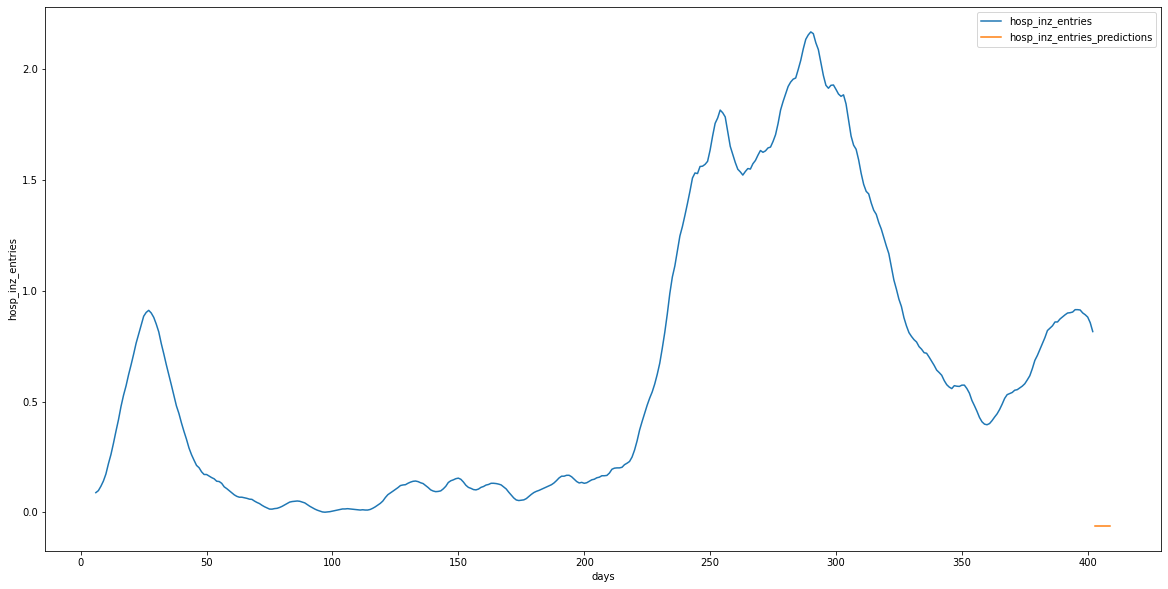

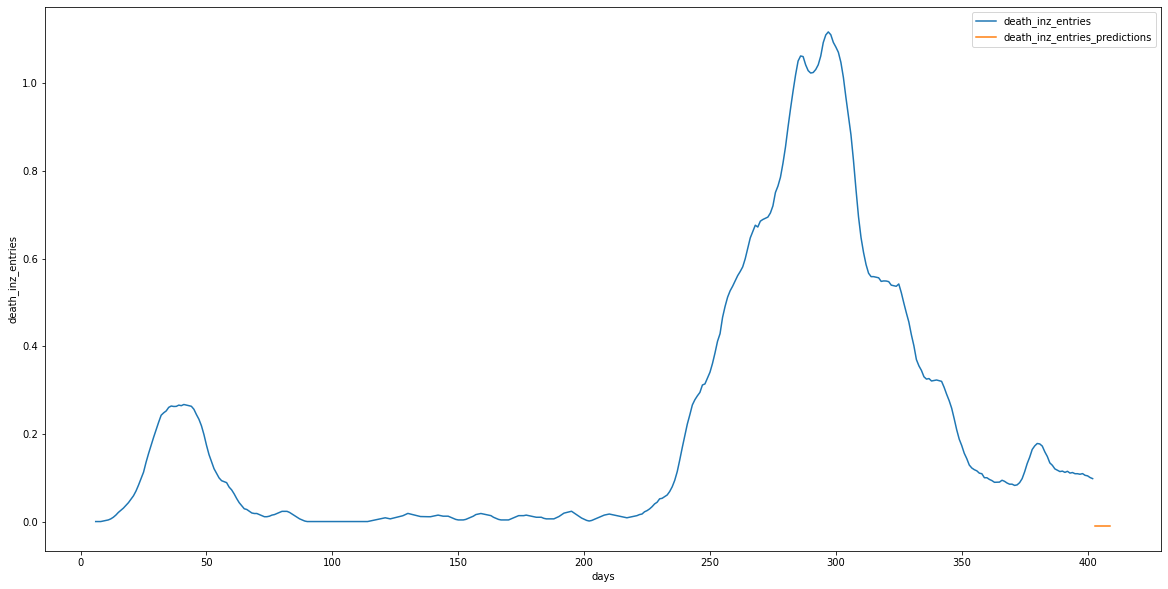

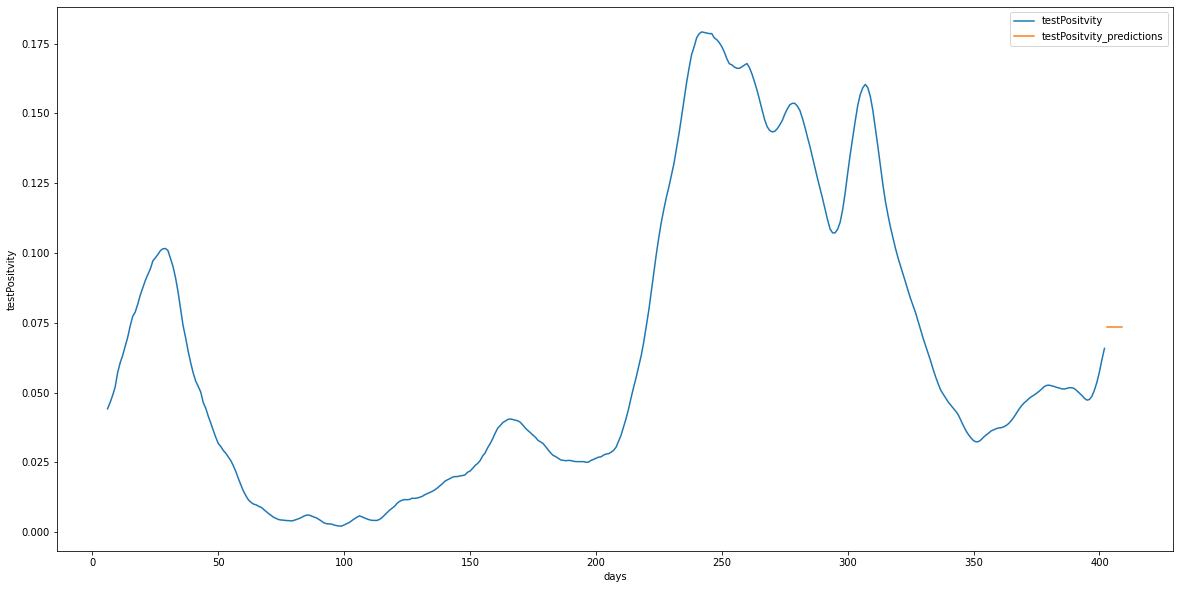

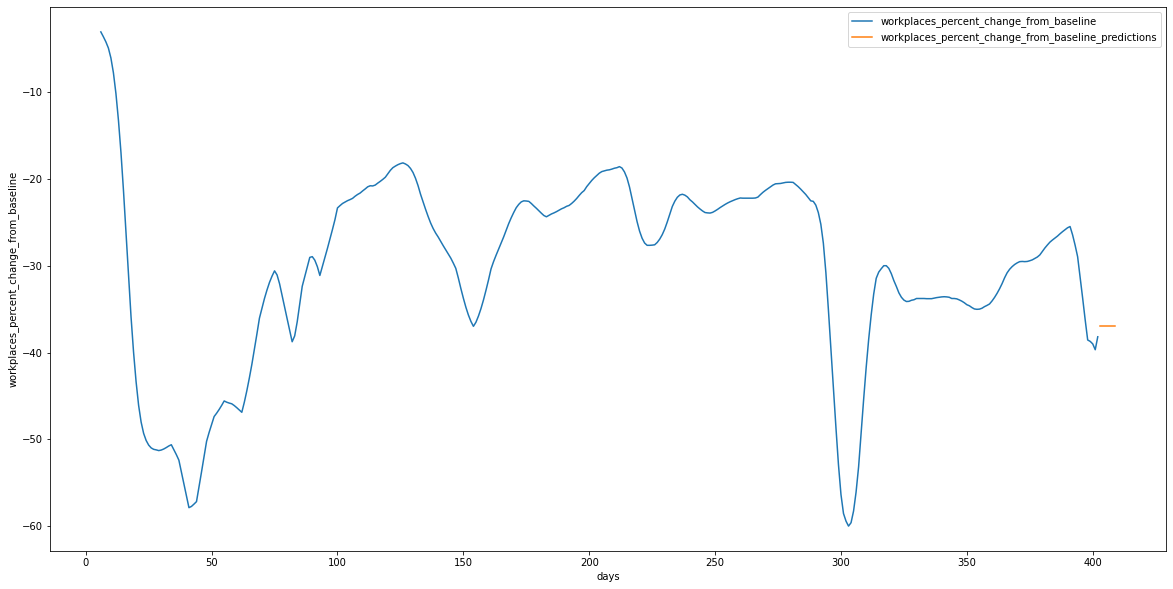

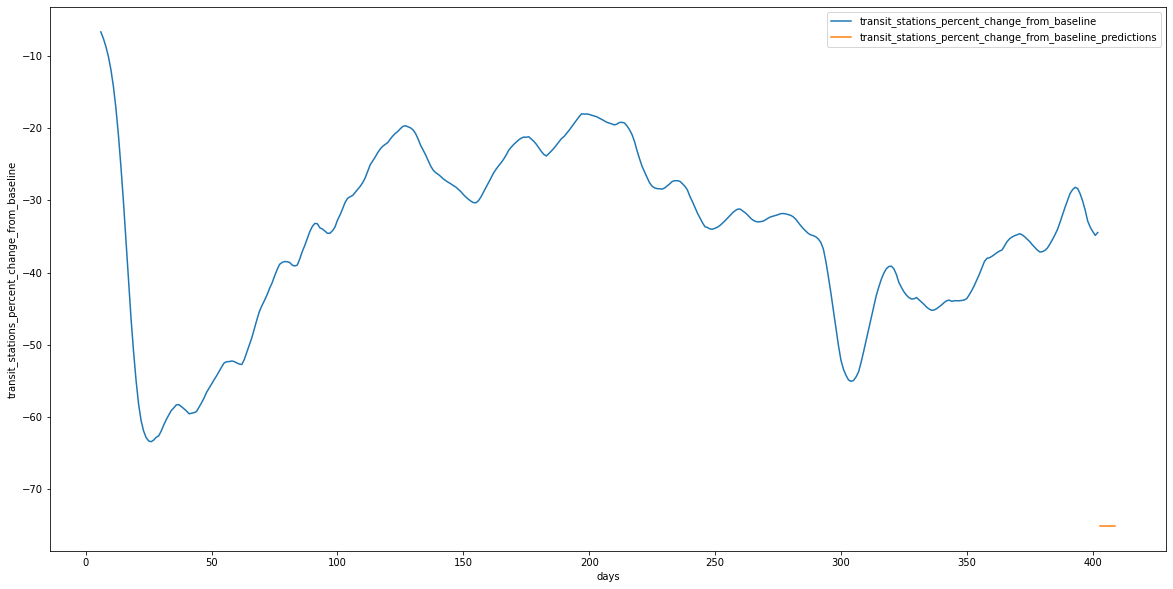

In [91]:
cantonId = 'ZH'
pastOutput = pd.read_csv("data/outputs/"+cantonId+".csv")



predDf = pd.DataFrame()
for col in pastOutput.columns:
    p = predictors[col].predict(pip.fit_transform(pd.read_csv("data/newest/"+cantonId+".csv")))[0]
    temp = pd.DataFrame([p for i in range(7)], columns=[col+"_predictions"])
    predDf = pd.concat([predDf,temp], axis=1)
df = pastOutput.append(predDf, ignore_index=True)
for col in pastOutput.columns:
    df[[col]] = df[[col]].rolling(window=7).mean()
    df[[col,col+"_predictions"]].plot(kind='line', y=[col,col+"_predictions"], figsize=(20,10), xlabel='days', ylabel=col)
    plt.show()

'---lightGBM---hosp_inz_entries---'

LGBMRegressor()

'Scores:[[0.54606974 0.32692317 0.32997304 0.58555813 0.36072815 0.45417249\n  0.40542873 1.2604255  0.38203848 0.25336888]]'

'Mean:0.4904686321905419'

'Standard deviation:0.27401244638422945'

<AxesSubplot:>

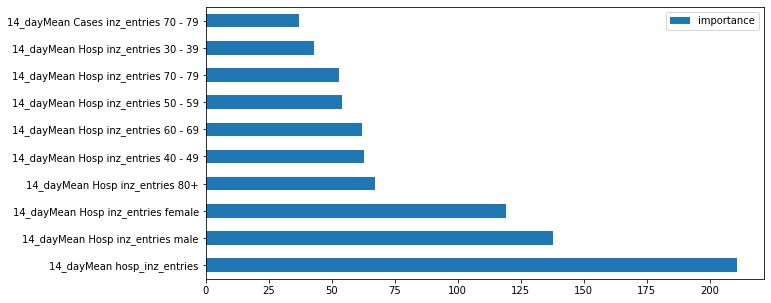

'----------End of evaluating (10.149593830108643)----------'

'---lightGBM---death_inz_entries---'

LGBMRegressor()

'Scores:[[0.25055136 0.16385501 0.1683983  0.32378267 0.15998122 0.19674389\n  0.17134421 0.23198164 0.26146191 0.12416444]]'

'Mean:0.20522646358172802'

'Standard deviation:0.05735350252198355'

<AxesSubplot:>

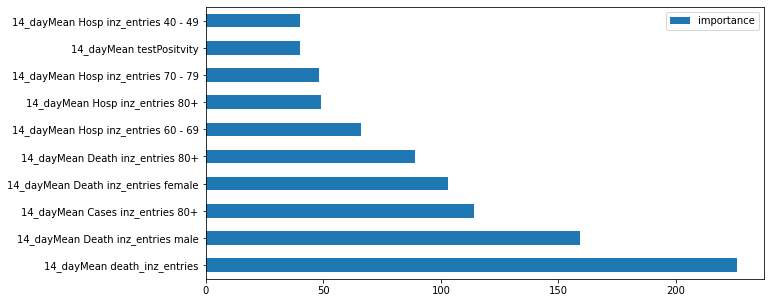

'----------End of evaluating (14.436281442642212)----------'

'---lightGBM---testPositvity---'

LGBMRegressor()

'Scores:[[0.0453466  0.01733249 0.03003177 0.05395812 0.02972314 0.03722021\n  0.02158541 0.0567575  0.04835395 0.02383305]]'

'Mean:0.036414224421573924'

'Standard deviation:0.013313263188862775'

<AxesSubplot:>

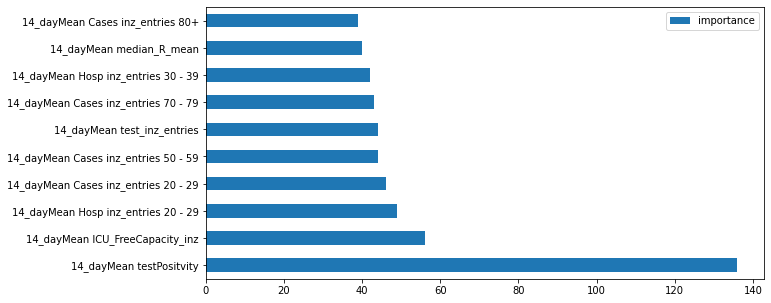

'----------End of evaluating (15.435147285461426)----------'

'---lightGBM---workplaces_percent_change_from_baseline---'

LGBMRegressor()

'Scores:[[3.39938401 3.13344961 3.8307205  5.22224168 4.55208952 2.98583356\n  2.64292149 4.67982501 4.27660828 5.00163929]]'

'Mean:3.9724712957614288'

'Standard deviation:0.8569454512349135'

<AxesSubplot:>

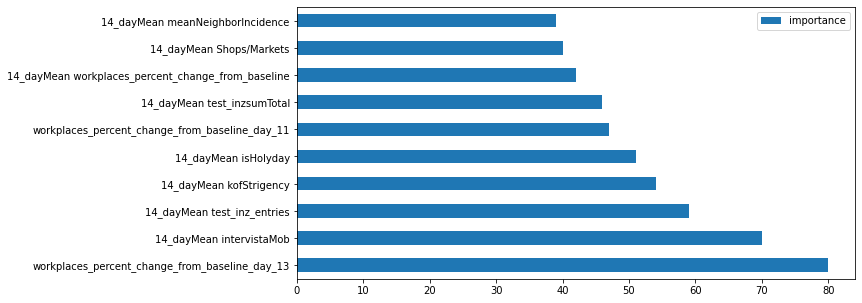

'----------End of evaluating (16.749470710754395)----------'

'---lightGBM---transit_stations_percent_change_from_baseline---'

LGBMRegressor()

'Scores:[[4.87721957 4.13589613 3.44556703 7.12947463 4.98023965 6.15356181\n  3.91472342 8.91379605 6.46185172 3.89299204]]'

'Mean:5.390532204625446'

'Standard deviation:1.6545911204632537'

<AxesSubplot:>

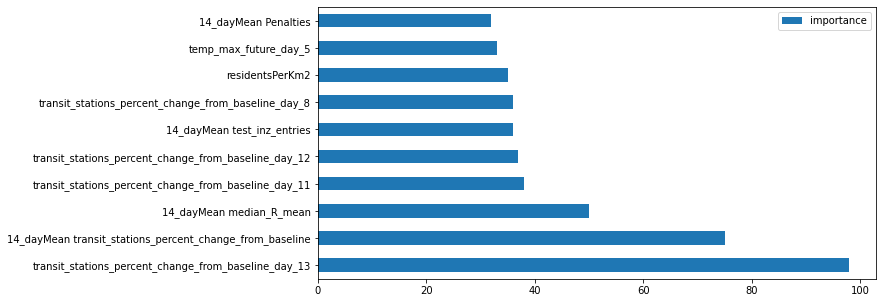

'----------End of evaluating (17.258830308914185)----------'

In [93]:
for label in predictingLabels:
    tl = train_labels[label].values
    
    # lightGBM
    display("---lightGBM---"+label+"---")
    start = time.time()
    parameters = {'n_estimators':[100]}
    reg = GridSearchCV(lightgbm.LGBMRegressor(), parameters, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')
    reg.fit(train_features, tl)
    #display(pd.DataFrame(reg.cv_results_))
    display(reg.best_estimator_)
    scores = pd.DataFrame(reg.cv_results_).loc[[reg.best_index_]][['split'+str(i)+'_test_score' for i in range(0,cv)]].values
    scores = np.sqrt(-scores)
    display("Scores:"+str(scores))
    display("Mean:"+str(scores.mean()))
    display("Standard deviation:"+str(scores.std()))
    #display(pd.DataFrame(reg.best_estimator_.feature_importances_.transpose(), index=featureNames, columns=['importance']).sort_values(['importance'], ascending=False))
    df = pd.DataFrame(reg.best_estimator_.feature_importances_.transpose(), index=featureNames, columns=['importance']).sort_values(['importance'], ascending=False)
    display(df[df['importance'] > 0].iloc[0:10].plot(kind='barh', y='importance', figsize=(10,5)))
    plt.show()
    display("----------End of evaluating (%s)----------" % (time.time() - start))

In [ ]:
'''
for label in predictingLabels:
    tl = train_labels[label].values
    
    # XGBoost
    display("---XGBoost---"+label+"---")
    start = time.time()
    parameters = {'n_estimators':[10], 'reg_alpha': [0], 'reg_lambda': [1]}
    reg = GridSearchCV(xgb.XGBRegressor(), parameters, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')
    reg.fit(train_features, tl)
    #display(pd.DataFrame(reg.cv_results_))
    #display(reg.best_estimator_.get_xgb_params())
    scores = pd.DataFrame(reg.cv_results_).loc[[reg.best_index_]][['split'+str(i)+'_test_score' for i in range(0,cv)]].values
    scores = np.sqrt(-scores)
    display("Scores:"+str(scores))
    display("Mean:"+str(scores.mean()))
    display("Standard deviation:"+str(scores.std()))
    display(pd.DataFrame(reg.best_estimator_.feature_importances_.transpose(), index=featureNames, columns=['importance']).sort_values(['importance'], ascending=False))
    display("----------End of evaluating (%s)----------" % (time.time() - start))
'''

In [ ]:
'''
# PCA
from sklearn.decomposition import IncrementalPCA

ipca = IncrementalPCA()
ipca.fit(train_features)
display(pd.DataFrame(ipca.singular_values_.transpose(), index=featureNames, columns=['singular value']).sort_values(['singular value'], ascending=False))
'''

In [ ]:
'''
for label in predictingLabels:
    tl = train_labels[label].values
    # Ridge regression
    display("---Ridge---"+label+"---")
    start = time.time()
    parameters = {'alpha':[0.1, 1, 10]}
    reg = GridSearchCV(linear_model.Ridge(), parameters, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')
    reg.fit(train_features, tl)
    display(reg.best_estimator_)
    scores = pd.DataFrame(reg.cv_results_).loc[[reg.best_index_]][['split'+str(i)+'_test_score' for i in range(0,cv)]].values
    scores = np.sqrt(-scores)
    display("Scores:"+str(scores))
    display("Mean:"+str(scores.mean()))
    display("Standard deviation:"+str(scores.std()))
    #display(pd.DataFrame(reg.best_estimator_.coef_.transpose(), index=featureNames, columns=['importance']).sort_values(['importance'], ascending=False))
    display("----------End of evaluating (%s)----------" % (time.time() - start))
'''

In [ ]:
'''
for label in predictingLabels:
    tl = train_labels[label].values

    # RandomForestRegressor
    display("---RandomForestRegressor---"+label+"---")
    start = time.time()
    parameters = {'n_estimators':[20]}
    reg = GridSearchCV(RandomForestRegressor(), parameters, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')
    reg.fit(train_features, tl)
    #display(pd.DataFrame(reg.cv_results_))
    display(reg.best_estimator_)
    scores = pd.DataFrame(reg.cv_results_).loc[[reg.best_index_]][['split'+str(i)+'_test_score' for i in range(0,cv)]].values
    scores = np.sqrt(-scores)
    display("Scores:"+str(scores))
    display("Mean:"+str(scores.mean()))
    display("Standard deviation:"+str(scores.std()))
    display(pd.DataFrame(reg.best_estimator_.feature_importances_.transpose(), index=featureNames, columns=['importance']).sort_values(['importance'], ascending=False))
    display("----------End of evaluating (%s)----------" % (time.time() - start))
'''

In [ ]:
'''
for label in predictingLabels:
    tl = train_labels[[label]].values
    tl = tl.ravel()

    # MLP regression
    display("---MLP---"+label+"---")
    start = time.time()
    parameters = {'hidden_layer_sizes':[(100)]}
    reg = GridSearchCV(MLPRegressor(), parameters, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')
    reg.fit(train_features, tl)
    #display(pd.DataFrame(reg.cv_results_))
    display(reg.best_estimator_)
    scores = pd.DataFrame(reg.cv_results_).loc[[reg.best_index_]][['split'+str(i)+'_test_score' for i in range(0,cv)]].values
    scores = np.sqrt(-scores)
    display("Scores:"+str(scores))
    display("Mean:"+str(scores.mean()))
    display("Standard deviation:"+str(scores.std()))
    display("----------End of evaluating (%s)----------" % (time.time() - start))
'''

In [ ]:
'''
for label in predictingLabels:
    tl = train_labels[label].values

    # SVR
    display("---SVR---"+label+"---")
    start = time.time()
    parameters = {'C':[0.1]}
    reg = GridSearchCV(svm.SVR(), parameters, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')
    reg.fit(train_features, tl)
    display(reg.best_estimator_)
    scores = pd.DataFrame(reg.cv_results_).loc[[reg.best_index_]][['split'+str(i)+'_test_score' for i in range(0,cv)]].values
    scores = np.sqrt(-scores)
    display("Scores:"+str(scores))
    display("Mean:"+str(scores.mean()))
    display("Standard deviation:"+str(scores.std()))
    display("----------End of evaluating (%s)----------" % (time.time() - start))
'''